<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/correlation/folder/SmallCap_Nifty_Corr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install quandl
#!pip install kneed


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import quandl
import pandas as pd
import numpy as np
import requests
from quandl.errors.quandl_error import NotFoundError
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn import preprocessing
import matplotlib
from kneed import DataGenerator, KneeLocator

In [3]:
startdate='2003-04-01'

In [4]:
bse_100=quandl.get('BSE/'+ 'BSE100',start_date=startdate, authtoken="1Mz3xLNFNdUpKENCkArB")

In [5]:
bse_100.head(2)

,Open,High,Low,Close
Date,,,,
2003-04-01,867.16,883.17,867.16,879.88
2003-04-02,881.04,894.53,881.04,893.08


In [6]:
bse_sml=quandl.get('BSE/'+ 'BSESML',start_date=startdate, authtoken="1Mz3xLNFNdUpKENCkArB")

In [7]:
data_subset=pd.DataFrame()
# data.insert(column position , column name , series_to_be_inserted)
data_subset.insert(0,'bse_100',bse_100['Close'])
data_subset.insert(1,'bse_sml',bse_sml['Close'])

In [8]:
data_subset.columns=['bse','sml']

In [9]:
#data_subset['ratio']=data_subset['bse']/data_subset['sml']

In [10]:
data_subset.tail(2)

,bse,sml
Date,,
2022-01-24,17396.16,28638.23
2022-01-25,17542.68,28869.33


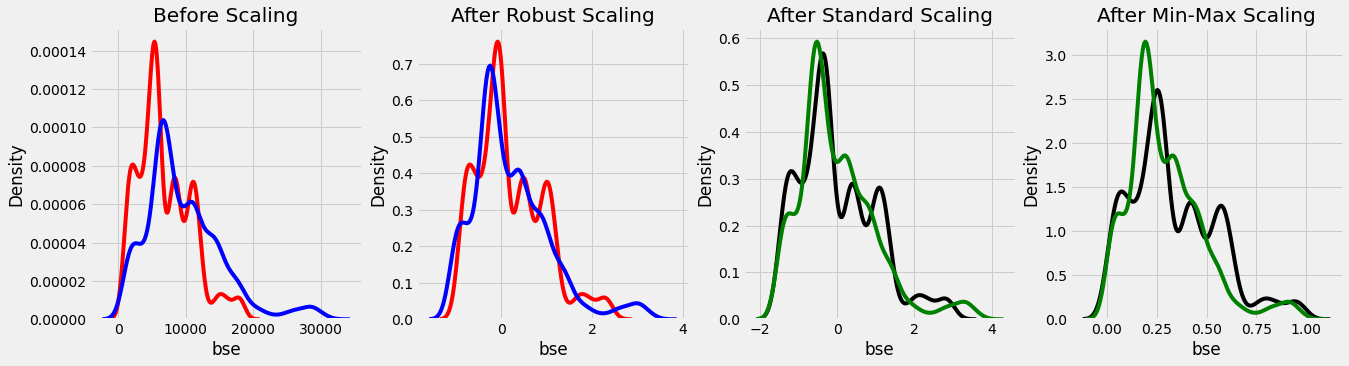

In [11]:
% matplotlib inline
matplotlib.style.use('fivethirtyeight')

# data
x = data_subset.copy()
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['bse','sml'])

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['bse','sml'])

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['bse','sml'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['bse'], ax = ax1, color ='r')
sns.kdeplot(x['sml'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')

sns.kdeplot(robust_df['bse'], ax = ax2, color ='red')
sns.kdeplot(robust_df['sml'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')

sns.kdeplot(standard_df['bse'], ax = ax3, color ='black')
sns.kdeplot(standard_df['sml'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')

sns.kdeplot(minmax_df['bse'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['sml'], ax = ax4, color ='g')
plt.show()

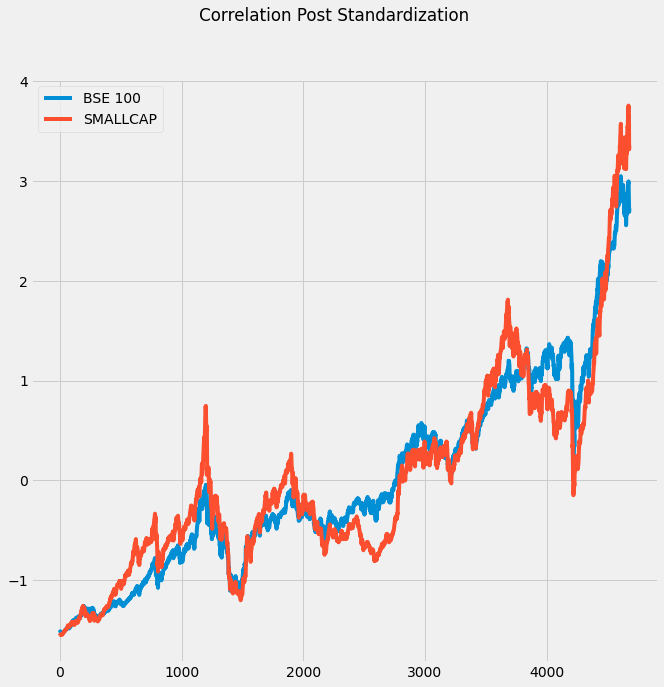

In [12]:
columns=['BSE 100','SMALLCAP']
standard_df.columns=columns
standard_df[:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

In [13]:
standard_df['diff']=standard_df['SMALLCAP']-standard_df['BSE 100']

In [14]:
result=np.log(standard_df['diff']).diff(60)

In [15]:
result=result.dropna()

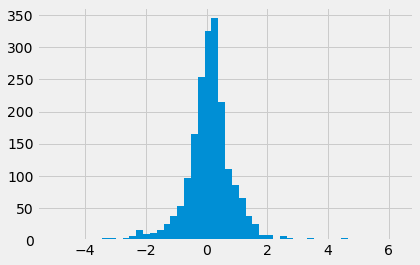

In [16]:
result.hist(bins=50);

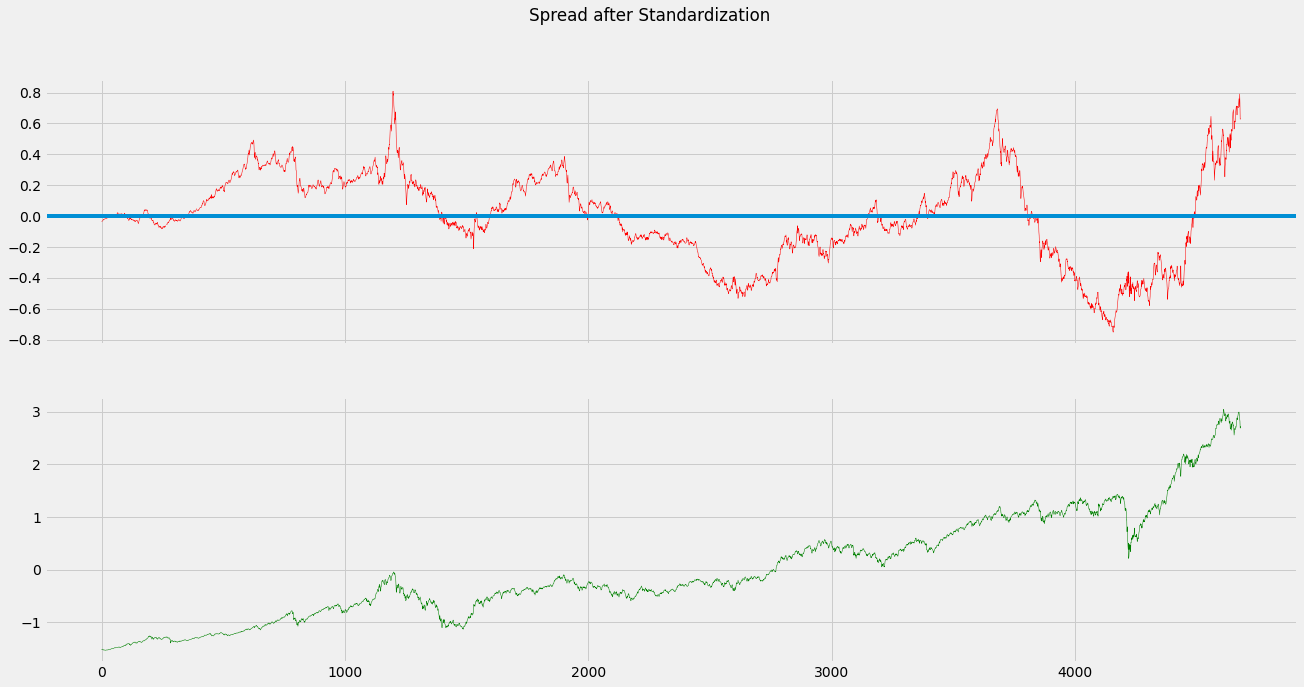

In [17]:
plt.rcParams["figure.figsize"] = (20,10)
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].plot(standard_df['diff'],linewidth=0.5,color='r')

ax[1].plot(standard_df['BSE 100'],linewidth=0.5,color='g')
ax[0].axhline(y=0)
plt.suptitle('Spread after Standardization')
plt.show()

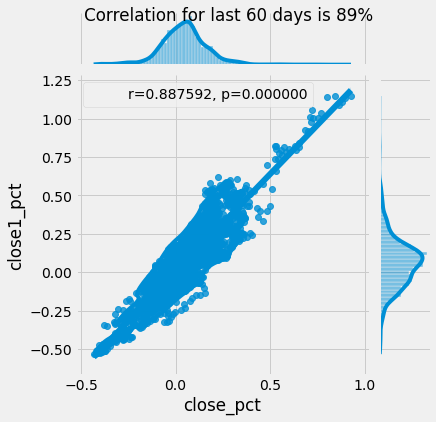

In [18]:
data_subset['close_pct']=data_subset['bse'].pct_change(60)
data_subset['close1_pct']=data_subset['sml'].pct_change(60)

data_subset.dropna(inplace=True)
g=sns.jointplot(x='close_pct',y='close1_pct',data=data_subset,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(data_subset['close_pct'], data_subset['close1_pct'])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.suptitle(f'Correlation for last 60 days is {round(r*100)}%')
plt.show()

In [19]:
standard_df.tail()

,BSE 100,SMALLCAP,diff
4675,2.906000,3.654596,0.748596
4676,2.866287,3.657136,0.790850
4677,2.821072,3.552164,0.731092
4678,2.691810,3.319039,0.627229
4679,2.729211,3.359578,0.630367


In [20]:
from sklearn.cluster import KMeans 

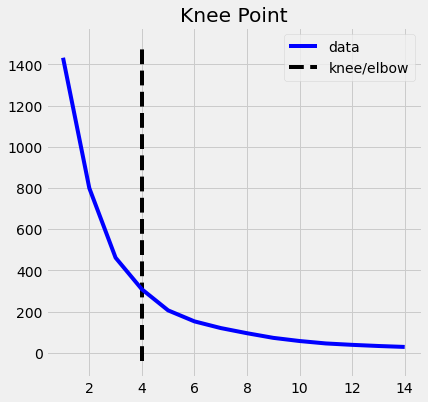

In [21]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(result.values.reshape(-1,1))
    sum_of_squared_distances.append(km.inertia_)
kn = KneeLocator(K, sum_of_squared_distances,S=1.0, curve="convex", direction="decreasing")
kn.plot_knee()

In [22]:
X=result.values.reshape(-1,1)

In [23]:
kmeans = KMeans(n_clusters= kn.knee).fit(X.reshape(-1,1))
c = kmeans.predict(X.reshape(-1,1))
minmax = []
for i in range(kn.knee):
    minmax.append([-np.inf,np.inf])
for i in range(len(X)):
    cluster = c[i]
    if X[i] > minmax[cluster][0]:
        minmax[cluster][0] = X[i]
    if X[i] < minmax[cluster][1]:
        minmax[cluster][1] = X[i]

In [24]:
y=X[-500:].copy()

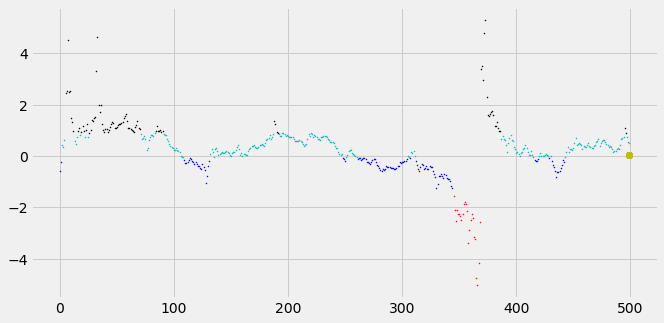

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5))
for i in range(len(y)):
    colors = ['b','k','r','c']
    c = kmeans.predict(y[i].reshape(-1,1))[0]
    color = colors[c]
    plt.scatter(i,y[i],c = color,s = 1)
    plt.scatter(len(y)-1,X[len(y)-1],c='y')

In [26]:
df_new=bse_100[-500:].copy()
X_new=X[-500:]

In [27]:
color

'c'

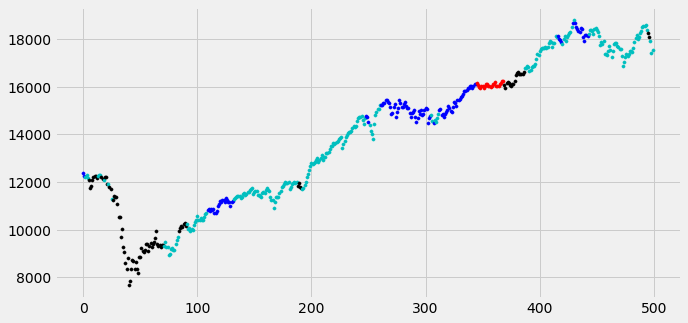

In [28]:
plt.figure(figsize=(10,5))

for i in range(len(df_new)):
    colors = ['b','k','r','c']
    c = kmeans.predict(X_new[i].reshape(-1,1))[0]
    color = colors[c]
    
    plt.scatter(i,df_new['Close'].iloc[i],c = color,s =10)

